## Train a ConvNet to recognize objects using the CIFAR dataset

In this tutorial, we train a ConvNet from scratch to do object recognition over 10 classes.
You would learn how to use Torch's neural network package and optim package to train a network.

In [1]:
-- require the necessary packages
require 'torch'
require 'nn'
require 'optim'
require 'image'
require 'xlua'


torch.setdefaulttensortype('torch.FloatTensor')

In [2]:
-- manually define the class-names in CIFAR-10 in a lua table
classes={'bridge', 'building', 'city', 'eiffel_tower','elephant', 'landscape', 'lion', 'monkey', 'people', 'tower', 'water'}


In [3]:
-- define model to train
model = nn.Sequential()
--[[ stage 1 : mean+std normalization -> filter bank -> squashing -> max pooling
model:add(nn.SpatialConvolutionMM(3,32,5,5))
model:add(nn.ReLU())
model:add(nn.SpatialMaxPooling(2, 2, 2, 2))
-- stage 2 : filter bank -> squashing -> max pooling
model:add(nn.SpatialConvolutionMM(32,32,5,5))
model:add(nn.ReLU())
model:add(nn.SpatialMaxPooling(2, 2, 2, 2))
]]
-- stage 3 : standard 2-layer neural network
model:add(nn.View(3*64*64))
model:add(nn.Linear(3*64*64, #classes))
--model:add(nn.ReLU())
--model:add(nn.Linear(128,#classes))
model:add(nn.LogSoftMax())


In [4]:
print(model:__tostring())

nn.Sequential {
  [input -> (1) -> (2) -> (3) -> output]
  (1): nn.View(12288)
  (2): nn.Linear(12288 -> 11)
  (3): nn.LogSoftMax
}	


In [5]:
-- retrieve parameters and gradients. this helps us to use the optim package
parameters,gradParameters = model:getParameters()

In [6]:
-- loss function: negative log-likelihood
criterion = nn.ClassNLLCriterion()
print (criterion)

nn.ClassNLLCriterion
{
  sizeAverage : true
  output : 0
  gradInput : FloatTensor - empty
  output_tensor : FloatTensor - size: 1
  target : LongTensor - size: 1
  total_weight_tensor : FloatTensor - size: 1
}


In [7]:
batchSize = 64 -- sets the mini-Batch size



In [25]:

imagesAll = torch.Tensor(1721,3,64,64) 
labelsAll = torch.IntTensor(1721)
compteur = 0
compteur2 = 0
for dir in paths.iterdirs("./dataset/train/") do
    compteur = compteur + 1
    files = {}
    for file in paths.files(paths.concat('./dataset/train/', dir)) do
       if file:find('JPEG' .. '$') then
          table.insert(files, paths.concat(paths.concat('./dataset/train/',dir), file))
       end
    end
   
    if #files == 0 then
       error('given directory doesnt contain any files of type: ')
    end

    print(#files)
    temp2 = compteur2
    temp3 = 0
    for i=1,(#files) do
        temp = image.load(files[i])

        if (temp:size()[1]==3) then
            compteur2 = compteur2 + 1
            imagesAll[temp2 + i - temp3] = image.load(files[i]) 
            labelsAll[temp2 + i - temp3] = compteur
            --print(temp2 + i, temp2 + i - temp3, dir, compteur, temp3)
        else 
            temp3 = temp3 + 1
        end
    end

    collectgarbage()
end

182	


157	


85	


17	


223	


44	


288	


215	


164	


153	


190	


In [13]:
trainData = {
   data = torch.Tensor(1673, 3, 64, 64),
   labels = torch.Tensor(1673),
   size = function() return 1673 end

}

for i=1,1673 do
   trainData.data[i] = imagesAll[i]
   trainData.labels[i] = labelsAll[i]
end

--trainData.labels = trainData.labels + 1
trainData.data = trainData.data:reshape(1673,3,64,64)

In [26]:

temp=0
for i=1,1672 do 
    if trainData.labels[i] == 0 then
        temp= temp+1
        print(i)
    end
end
print (temp)


bad argument #2 to '?' (out of range at /Users/danconstantini/torch/pkg/torch/generic/Tensor.c:888)
stack traceback:
	[C]: at 0x059df0a0
	[C]: in function '__index'
	[string "..."]:4: in main chunk
	[C]: in function 'xpcall'
	...nconstantini/torch/install/share/lua/5.1/itorch/main.lua:179: in function <...nconstantini/torch/install/share/lua/5.1/itorch/main.lua:143>
	...nconstantini/torch/install/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	...nstantini/torch/install/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	...nstantini/torch/install/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	...nstantini/torch/install/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	...nconstantini/torch/install/share/lua/5.1/itorch/main.lua:350: in main chunk
	[C]: in function 'require'
	(command line):1: in main chunk
	[C]: at 0x0105659bb0: 

In [16]:
-- preprocess/normalize train/test sets
-- preprocess trainSet
collectgarbage()



normalization = nn.SpatialContrastiveNormalization(1, image.gaussian1D(7))

for i = 1,1673 do
   -- rgb -> yuv
   local rgb = trainData.data[i]
   local yuv = image.rgb2yuv(rgb)
   -- normalize y locally:
   yuv[1] = normalization(yuv[{{1}}])
   trainData.data[i] = yuv
end
-- normalize u globally:
mean_u = trainData.data[{ {},2,{},{} }]:mean()
std_u = trainData.data[{ {},2,{},{} }]:std()
trainData.data[{ {},2,{},{} }]:add(-mean_u)
trainData.data[{ {},2,{},{} }]:div(-std_u)
-- normalize v globally:
mean_v = trainData.data[{ {},3,{},{} }]:mean()
std_v = trainData.data[{ {},3,{},{} }]:std()
trainData.data[{ {},3,{},{} }]:add(-mean_v)
trainData.data[{ {},3,{},{} }]:div(-std_v)


In [17]:
collectgarbage()
--trainData.data:mul(10000)

In [18]:
-- this matrix records the current confusion across classes
confusion = optim.ConfusionMatrix(classes)

In [19]:
-- define training and testing functions

In [20]:
-- training function
function train(dataset)
   -- epoch tracker
   epoch = epoch or 1

   -- do one epoch
   print('<trainer> on training set:')
   print("<trainer> online epoch # " .. epoch .. ' [batchSize = ' .. batchSize .. ']')
   for t = 1,dataset:size(),batchSize do

      -- create mini batch
      local inputs = {}
      local targets = {}
      for i = t,math.min(t+batchSize-1,dataset:size()) do
         -- load new sample
         local input = dataset.data[i]
         local target = dataset.labels[i]
         table.insert(inputs, input)
         table.insert(targets, target)
      end
      -- create closure to evaluate f(X) and df/dX
      local feval = function(x)
                       -- get new parameters
                       if x ~= parameters then
                          parameters:copy(x)
                       end

                       -- reset gradients
                       gradParameters:zero()

                       -- f is the average of all criterions
                       local f = 0

                       -- evaluate function for complete mini batch
                       for i = 1,#inputs do
                          -- estimate f
                          local output = model:forward(inputs[i])
                          local err = criterion:forward(output, targets[i])
                          f = f + err

                          -- estimate df/dW
                          local df_do = criterion:backward(output, targets[i])
                          model:backward(inputs[i], df_do)

                          -- update confusion
                          confusion:add(output, targets[i])                        
                       end

                       -- normalize gradients and f(X)
                       gradParameters:div(#inputs)
                       f = f/#inputs

                       -- return f and df/dX
                       return f,gradParameters
                    end


      config = config or {learningRate = 1e-3,
              weightDecay = 0,
                momentum = 0,
              learningRateDecay = 5e-7}
      optim.sgd(feval, parameters, config)
   end

   -- print confusion matrix
   print(confusion)
   confusion:zero()

   -- next epoch
   epoch = epoch + 1
end


In [21]:
-- test function
function test(dataset)

   -- test over given dataset
   print('<trainer> on testing Set:')
   for t = 1,dataset:size() do
      -- get new sample
      local input = dataset.data[t]
      local target = dataset.labels[t]

      -- test sample
      local pred = model:forward(input)
      confusion:add(pred, target)
   end

   -- print confusion matrix
   print(confusion)
   confusion:zero()

end


In [24]:
i=0
while i<10 do
train(trainData)
i=i+1
end

<trainer> on training set:	
<trainer> online epoch # 3 [batchSize = 64]	


ConfusionMatrix:
[[      47      16      15       6       8       7      22       9       6      20      25]   25.967% 	[class: bridge]
 [      13      52       4       1      11      11      11       4       7      20      18]   34.211% 	[class: building]
 [      16       8      11       3       6       3      10       5       7       4       8]   13.580% 	[class: city]
 [       1       1       0       1       1       1       4       1       0       3       3]   6.250% 	[class: eiffel_tower]
 [      14      23       9      12      60      10      32      14      17      13      14]   27.523% 	[class: elephant]
 [      11       4       5       1       0       2       4       3       2       8       4]   4.545% 	[class: landscape]
 [       6      15      10      13      19      14     155      15      19       5      12]   54.770% 	[class: lion]
 [      20      14      13      13      19      12      42      47      11       9      13]   22.066% 	[class: monkey]
 [       7      11      

ConfusionMatrix:
[[      68      13      11       5       6       4      24       5       5      19      21]   37.569% 	[class: bridge]
 [      11      65       2       1       9       6      10       4       5      24      15]   42.763% 	[class: building]
 [      16       6      18       2       5       2      10       5       6       4       7]   22.222% 	[class: city]
 [       1       1       0       1       1       0       4       1       1       3       3]   6.250% 	[class: eiffel_tower]
 [      12      21       6       7      78       8      35      13      17      10      11]   35.780% 	[class: elephant]
 [      10       6       5       1       1       3       4       1       2       8       3]   6.818% 	[class: landscape]
 [       6      10       6       7      17       8     185      14      16       4      10]   65.371% 	[class: lion]
 [      17      13      11      11      18      10      45      56      10       9      13]   26.291% 	[class: monkey]
 [       7      10      

ConfusionMatrix:
[[      80      11       9       5       4       4      24       5       4      19      16]   44.199% 	[class: bridge]
 [      11      80       2       1       8       8       9       4       3      19       7]   52.632% 	[class: building]
 [      17       4      27       1       2       1      11       4       6       3       5]   33.333% 	[class: city]
 [       2       1       0       1       1       0       2       1       1       4       3]   6.250% 	[class: eiffel_tower]
 [      12      20       4       6     100       8      29      11      10       8      10]   45.872% 	[class: elephant]
 [       8       8       4       1       0       7       4       0       1       8       3]   15.909% 	[class: landscape]
 [       6       9       4       6      13       5     203      11      14       3       9]   71.731% 	[class: lion]
 [      17      12       4       9      19       6      44      73      10       9      10]   34.272% 	[class: monkey]
 [       6       9     

ConfusionMatrix:
[[      93      10       8       2       4       3      23       5       4      14      15]   51.381% 	[class: bridge]
 [      11      89       2       1       7       5       9       4       2      16       6]   58.553% 	[class: building]
 [      16       2      33       1       2       0      11       4       5       2       5]   40.741% 	[class: city]
 [       1       0       0       1       1       0       3       1       1       5       3]   6.250% 	[class: eiffel_tower]
 [      10      16       3       6     113       7      26      11       9       9       8]   51.835% 	[class: elephant]
 [       7       7       3       1       0      11       5       0       0       8       2]   25.000% 	[class: landscape]
 [       7       8       4       5      11       2     216       9      12       3       6]   76.325% 	[class: lion]
 [      14       9       3       8      19       4      42      90       7       7      10]   42.254% 	[class: monkey]
 [       6       8     

ConfusionMatrix:
[[     105       7       7       1       3       2      22       4       4      14      12]   58.011% 	[class: bridge]
 [       8     100       2       1       4       4       9       4       2      15       3]   65.789% 	[class: building]
 [      15       2      42       1       1       0       8       3       3       2       4]   51.852% 	[class: city]
 [       1       0       0       1       1       0       3       1       1       5       3]   6.250% 	[class: eiffel_tower]
 [       9      13       2       5     134       5      21       9       7       7       6]   61.468% 	[class: elephant]
 [       5       5       2       0       0      19       4       0       0       7       2]   43.182% 	[class: landscape]
 [       7       9       1       3       9       2     228       6       8       3       7]   80.565% 	[class: lion]
 [      13       6       2       5      17       4      35     112       6       6       7]   52.582% 	[class: monkey]
 [       4      10     

ConfusionMatrix:
[[     116       6       6       0       3       1      18       4       4      13      10]   64.088% 	[class: bridge]
 [       7     109       1       1       5       2       8       3       2      11       3]   71.711% 	[class: building]
 [      13       2      47       1       1       0       7       3       3       2       2]   58.025% 	[class: city]
 [       1       0       0       2       0       0       3       1       1       5       3]   12.500% 	[class: eiffel_tower]
 [       5       9       0       2     163       2      16       6       7       5       3]   74.771% 	[class: elephant]
 [       5       4       2       0       0      23       4       0       0       5       1]   52.273% 	[class: landscape]
 [       5      10       1       2       7       1     236       5       7       3       6]   83.392% 	[class: lion]
 [      12       5       2       4      15       3      29     125       7       4       7]   58.685% 	[class: monkey]
 [       3       9    

  nclasses : 11
  _max : FloatTensor - size: 1
  _target : FloatTensor - empty
  unionvalids : FloatTensor - size: 11
  totalValid : 0.69515839808727
}
<trainer> on training set:	
<trainer> online epoch # 9 [batchSize = 64]	


ConfusionMatrix:
[[     131       4       4       0       2       1      15       3       4      11       6]   72.376% 	[class: bridge]
 [       7     121       1       0       5       0       4       3       0       8       3]   79.605% 	[class: building]
 [      10       2      57       0       0       0       4       3       3       1       1]   70.370% 	[class: city]
 [       1       0       0       2       0       0       2       2       1       5       3]   12.500% 	[class: eiffel_tower]
 [       4       9       0       1     171       2      15       3       5       5       3]   78.440% 	[class: elephant]
 [       5       3       2       0       0      26       3       0       0       4       1]   59.091% 	[class: landscape]
 [       4      11       0       0       7       0     245       3       6       3       4]   86.572% 	[class: lion]
 [      12       5       1       3      13       2      22     140       7       3       5]   65.728% 	[class: monkey]
 [       3       9    

ConfusionMatrix:
[[     137       4       2       0       2       1      14       2       4      10       5]   75.691% 	[class: bridge]
 [       7     125       0       0       5       0       3       2       0       7       3]   82.237% 	[class: building]
 [       8       3      61       0       0       0       3       3       2       1       0]   75.309% 	[class: city]
 [       1       0       0       2       0       0       2       2       1       5       3]   12.500% 	[class: eiffel_tower]
 [       4       5       0       1     187       0      13       2       3       2       1]   85.780% 	[class: elephant]
 [       5       3       2       0       0      27       3       0       0       3       1]   61.364% 	[class: landscape]
 [       3      10       0       0       6       0     250       3       6       3       2]   88.339% 	[class: lion]
 [      12       5       1       2      10       1      18     154       5       1       4]   72.300% 	[class: monkey]
 [       2       9    

<trainer> on training set:	
<trainer> online epoch # 11 [batchSize = 64]	


ConfusionMatrix:
[[     144       4       2       0       2       0      12       2       4       7       4]   79.558% 	[class: bridge]
 [       7     128       0       0       4       0       3       2       0       6       2]   84.211% 	[class: building]
 [       7       3      64       0       0       0       2       2       2       1       0]   79.012% 	[class: city]
 [       1       0       0       3       0       0       2       1       1       5       3]   18.750% 	[class: eiffel_tower]
 [       2       5       0       1     192       0      10       2       3       2       1]   88.073% 	[class: elephant]
 [       4       2       2       0       0      32       2       0       0       1       1]   72.727% 	[class: landscape]
 [       3      10       0       0       5       0     253       2       5       3       2]   89.399% 	[class: lion]
 [       8       4       1       1       9       1      15     168       4       0       2]   78.873% 	[class: monkey]
 [       2       7    

      6 : landscape
      7 : lion
      8 : monkey
      9 : people
      10 : tower
      11 : water
    }
  _prediction : FloatTensor - size: 11
  _pred_idx : LongTensor - size: 1
  nclasses : 11
  _max : FloatTensor - size: 1
  _target : FloatTensor - empty
  unionvalids : FloatTensor - size: 11
  totalValid : 0.82606096832038
}
<trainer> on training set:	
<trainer> online epoch # 12 [batchSize = 64]	


ConfusionMatrix:
[[     153       3       2       0       1       0       9       2       3       6       2]   84.530% 	[class: bridge]
 [       6     132       0       0       4       0       3       2       0       4       1]   86.842% 	[class: building]
 [       5       3      66       0       0       0       2       2       2       1       0]   81.481% 	[class: city]
 [       1       0       0       7       0       0       1       1       0       5       1]   43.750% 	[class: eiffel_tower]
 [       1       5       0       0     198       0       7       2       2       2       1]   90.826% 	[class: elephant]
 [       3       2       1       0       0      35       2       0       0       0       1]   79.545% 	[class: landscape]
 [       3       5       0       0       4       0     261       1       4       3       2]   92.226% 	[class: lion]
 [       7       3       0       1       7       0      11     179       3       1       1]   84.038% 	[class: monkey]
 [       2       5    

In [ ]:
torch.save('model1layer.net',model)

0.15544034851502	


-0.16365542069888	


In [18]:
torch.save('model1.net', model)

In [17]:
timer = torch.Timer()
test(testData)
print (timer:time().real)

<trainer> on testing Set:	


ConfusionMatrix:
[[      24       8       8       5       2       2       8       6      24      16]   23.301% 	[class: airplane]
 [       4      58       1       4       0       0       7       4       1      10]   65.169% 	[class: automobile]
 [       5       5      28      11       8       4      20       7       8       4]   28.000% 	[class: bird]
 [       3       7      11      30       3       6      30       3       5       5]   29.126% 	[class: cat]
 [       4       1      10       8      12       1      37      11       4       2]   13.333% 	[class: deer]
 [       1       5       9      25       4      10      20       4       3       5]   11.628% 	[class: dog]
 [       0       1       3      20       3       5      71       2       3       4]   63.393% 	[class: frog]
 [       5       3       7       8       7       6      13      47       2       4]   46.078% 	[class: horse]
 [      22       9       4       6       2       0       1       4      51       7]   48.113% 	[class:

In [71]:
trainData.labels[1000]

9	


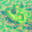

ConfusionMatrix:
[[       0       0       0       0       0       0       0       0       0       0]   nan% 	[class: airplane]
 [       0       0       0       0       0       0       0       0       0       0]   nan% 	[class: automobile]
 [       0       0       0       0       0       0       0       0       0       0]   nan% 	[class: bird]
 [       0       0       0       0       0       0       0       0       0       0]   nan% 	[class: cat]
 [       0       0       0       0       0       0       0       0       0       0]   nan% 	[class: deer]
 [       0       0       0       0       0       0       0       0       0       0]   nan% 	[class: dog]
 [       0       0       0       0       0       0       1       0       0       0]   100.000% 	[class: frog]
 [       0       0       0       0       0       0       0       0       0       0]   nan% 	[class: horse]
 [       0       0       0       0       0       0       0       0       0       0]   nan% 	[class: ship]
 [       0      

In [57]:







j=50
confusion:zero()


itorch.image(testData.data[j])
inp= testData.data[j]
tar= testData.labels[j]

pred = model:forward(inp)
confusion:add(pred, tar)
print(confusion)



In [22]:
print (pred)

-1.1657
-2.3892
-2.5634
-4.5198
-4.0242
-5.7736
-6.7106
-5.2705
-0.9884
-2.2155
[torch.DoubleTensor of dimension 10]



In [41]:
for i=1,100 and i~=5) do
    print(i)
end

[string "for (i=1,100 and i~=5) do..."]:1: '<name>' expected near '(': 

In [38]:
1~=2

true	
